## Comprehensive Data Exploration with Python (adapted)

- By: [Pedro Marcelino](http://pmarcelino.com) - February 2017
- Kaggle Code: [here](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python)
- **About**: Great starting point fro Kaggle Housing Prices COmpetition

### 0. Library and data loading

In [1]:
import pandas as pd
import numpy as np

# Data visualization-------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, probplot

# MICE imputation----------------------------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 
from sklearn.ensemble import RandomForestRegressor

# XGBoost------------------------------------------------------------
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import ElasticNet, ElasticNetCV # To prevent overfitting
from sklearn.feature_selection import SelectFromModel

# Load Dataset-------------------------------------------------------
df_train = pd.read_csv("./CSV/train.csv")
df_test  = pd.read_csv("./CSV/test.csv")


print('Train shape:', df_train.shape)
print('Test shape :', df_test.shape)
print('SalePrice appears in train and not in test, that explain the column number difference.')
print('Features:', df_train.columns)

import time
import joblib
import warnings
warnings.filterwarnings("ignore")

Train shape: (1460, 81)
Test shape : (1459, 80)
SalePrice appears in train and not in test, that explain the column number difference.
Features: Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplace

### 1. Feature analysis

#### 1. 1. Initial feature study: `feature_study.csv`

**Name**: `feature_study.csv`.  
**Column names**:
- Feature **name**: name.
- **Type**: continuos vs. discrete.
- **Segment**: defined as **space**, **building** and **location**.
- **Expectation** (**6th sense**): what we think impacts *SalePrice* (**High**, **Medium** and **Low**).
  - Do we think about this feature?
  - How important is it?
  - Information given by other feature?
- **Conclusion**: what we think after study of data. Same scale as Expectation.
- **Comments**: general info.
Review **High Expectation** defined features and make **scatter plots** with *SalePrice*, filling the *Conclusion* column.

#### 1. 2. Feature-categorical separation and conversion

- Separation of **Numerical** and **Discrete** features (counting *scores* as numerical).
- Study of **Discrete** features and looking out for visual correlation with `SalePrice`.
- Study **Discrete** features to visualize their correlation with `SalePrice`.  
- Study selected **Numerical** features to visualize their correlation with `SalePrice`.  
- Convert **Scored-Numerical** features into **Numerical** features for analysis.

In [2]:
# Separation
num_feats = [
    'Street', 'Alley', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF',
    'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
    'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
    'Fireplaces', 'FireplaceQu', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
    'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
    'PoolArea', 'PoolQC', 'Fence', 'MiscVal', 'SalePrice'
]

dis_feats = [
    'Id', 'MSSubClass', 'MSZoning', 'LotShape', 'LandContour',
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
    'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd',
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
    'Foundation', 'Heating', 'Electrical', 'GarageType', 'GarageYrBlt',
    'GarageFinish', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'
]

# Special study cases
dis_feats_1 = ['Id', 'MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd']
dis_feats_2 = ['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation']
dis_feats_3 = ['Heating', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
num_feats_4 = ['PoolQC', 'Fence']

print('Total:', len(df_train.columns))
print('Discrete:', len(dis_feats))
print('Numerical:', len(num_feats))
print('Total:', len(dis_feats) + len(num_feats))

Total: 81
Discrete: 31
Numerical: 50
Total: 81


In [3]:
# EVALUATE THIS CELL ONLY ONCE
# Conversion and normalization of df_train features
df_train['MSSubClass'] = df_train['MSSubClass'].astype(str)
df_train['Street'] = df_train['Street'].map({'Grvl':1, 'Pave':0})
df_train['Alley'] = df_train['Alley'].map({'Grvl':1, 'Pave':0.5, 'NA': 0})
df_train['Alley'] = df_train['Alley'].fillna(0)
df_train['YearBuilt'] = df_train['YearBuilt']
df_train['YearRemodAdd'] = df_train['YearRemodAdd']
df_train['ExterQual'] = df_train['ExterQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}) / 5
df_train['ExterCond'] = df_train['ExterCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}) / 5
df_train['BsmtQual'] = df_train['BsmtQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0})  / 5
df_train['BsmtQual'] = df_train['BsmtQual'].fillna(0)
df_train['BsmtCond'] = df_train['BsmtCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}) / 5
df_train['BsmtCond'] = df_train['BsmtCond'].fillna(0)
df_train['BsmtExposure'] = df_train['BsmtExposure'].map({'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}) / 4
df_train['BsmtExposure'] = df_train['BsmtExposure'].fillna(0)
df_train['BsmtFinType1'] = df_train['BsmtFinType1'].map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}) / 6
df_train['BsmtFinType1'] = df_train['BsmtFinType1'].fillna(0)
df_train['BsmtFinType2'] = df_train['BsmtFinType2'].map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}) / 6
df_train['BsmtFinType2'] = df_train['BsmtFinType2'].fillna(0)
df_train['HeatingQC'] = df_train['HeatingQC'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}) / 5
df_train['CentralAir'] = df_train['CentralAir'].map({'Y':1, 'N':0})
df_train['KitchenQual'] = df_train['KitchenQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
df_train['Functional'] = df_train['Functional'].map({'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0})
df_train['FireplaceQu'] = df_train['FireplaceQu'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}) / 5
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna(0)
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].astype('Int64')
df_train['GarageQual'] = df_train['GarageQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}) / 5
df_train['GarageQual'] = df_train['GarageQual'].fillna(0)
df_train['GarageCond'] = df_train['GarageCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}) / 5
df_train['GarageCond'] = df_train['GarageCond'].fillna(0)
df_train['PavedDrive'] = df_train['PavedDrive'].map({'Y':2, 'P': 1, 'N':0}) / 2
df_train['PoolQC'] = df_train['PoolQC'].notna().astype(int)
df_train['Fence'] = df_train['Fence'].notna().astype(int)
df_train['MoSold'] = df_train['MoSold'].astype(str)
df_train['YrSold'] = df_train['YrSold']

# Conversion and normalization of df_test features
df_test['MSSubClass'] = df_test['MSSubClass'].astype(str)
df_test['Street'] = df_test['Street'].map({'Grvl':1, 'Pave':0})
df_test['Alley'] = df_test['Alley'].map({'Grvl':1, 'Pave':0.5, 'NA': 0})
df_test['Alley'] = df_test['Alley'].fillna(0)
df_test['YearBuilt'] = df_test['YearBuilt']
df_test['YearRemodAdd'] = df_test['YearRemodAdd']
df_test['ExterQual'] = df_test['ExterQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}) / 5
df_test['ExterCond'] = df_test['ExterCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}) / 5
df_test['BsmtQual'] = df_test['BsmtQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}) / 5
df_test['BsmtQual'] = df_test['BsmtQual'].fillna(0)
df_test['BsmtCond'] = df_test['BsmtCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}) / 5
df_test['BsmtCond'] = df_test['BsmtCond'].fillna(0)
df_test['BsmtExposure'] = df_test['BsmtExposure'].map({'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}) / 4
df_test['BsmtExposure'] = df_test['BsmtExposure'].fillna(0)
df_test['BsmtFinType1'] = df_test['BsmtFinType1'].map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}) / 6
df_test['BsmtFinType1'] = df_test['BsmtFinType1'].fillna(0)
df_test['BsmtFinType2'] = df_test['BsmtFinType2'].map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}) / 6
df_test['BsmtFinType2'] = df_test['BsmtFinType2'].fillna(0)
df_test['HeatingQC'] = df_test['HeatingQC'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}) / 5
df_test['CentralAir'] = df_test['CentralAir'].map({'Y':1, 'N':0})
df_test['KitchenQual'] = df_test['KitchenQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
df_test['Functional'] = df_test['Functional'].map({'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0})
df_test['FireplaceQu'] = df_test['FireplaceQu'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}) / 5
df_test['FireplaceQu'] = df_test['FireplaceQu'].fillna(0)
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].astype('Int64')
df_test['GarageQual'] = df_test['GarageQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}) / 5
df_test['GarageQual'] = df_test['GarageQual'].fillna(0)
df_test['GarageCond'] = df_test['GarageCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}) / 5
df_test['GarageCond'] = df_test['GarageCond'].fillna(0)
df_test['PavedDrive'] = df_test['PavedDrive'].map({'Y':2, 'P': 1, 'N':0}) / 2
df_test['PoolQC'] = df_test['PoolQC'].notna().astype(int)
df_test['Fence'] = df_test['Fence'].notna().astype(int)
df_test['MoSold'] = df_test['MoSold'].astype(str)
df_test['YrSold'] = df_test['YrSold']

print('Train shape:', df_train.shape)
print('Test shape :', df_test.shape)

Train shape: (1460, 81)
Test shape : (1459, 80)


### 2. Correlation Matrix and Feature independence

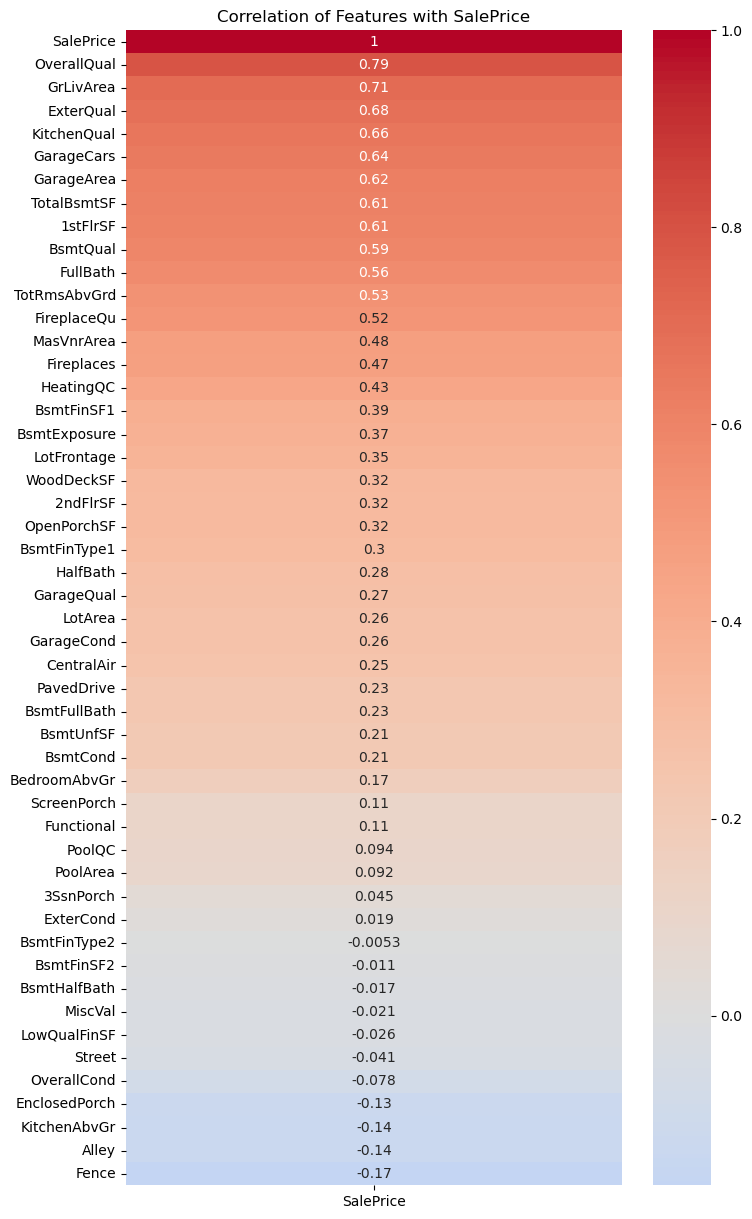

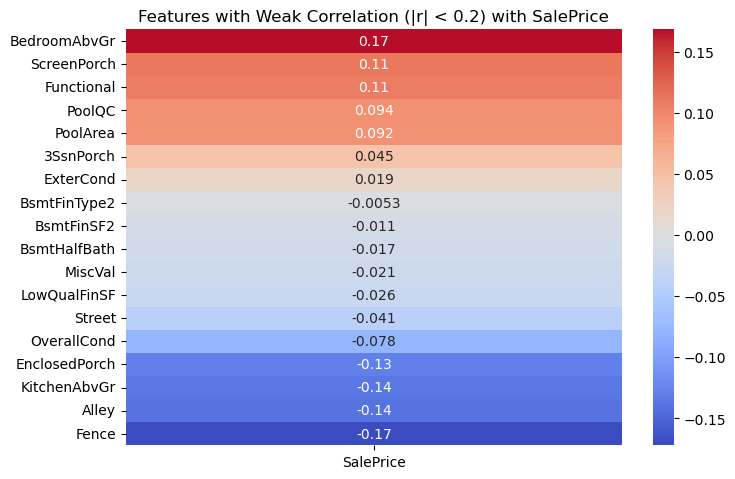


⚠️ Weakly correlated features (|r| < 0.2):
['BedroomAbvGr', 'ScreenPorch', 'Functional', 'PoolQC', 'PoolArea', '3SsnPorch', 'ExterCond', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'LowQualFinSF', 'Street', 'OverallCond', 'EnclosedPorch', 'KitchenAbvGr', 'Alley', 'Fence']


In [4]:
corr_matrix = df_train[num_feats].corr()
corr_with_saleprice = corr_matrix['SalePrice'].sort_values(ascending=False)

# --- 2. Heatmap of all correlations with SalePrice ---
plt.figure(figsize=(8, len(num_feats) * 0.3)); sns.heatmap(corr_with_saleprice.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Features with SalePrice'); plt.show()

# --- 3. Heatmap: features with |correlation| < 0.2 ---
low_corr_feats = corr_with_saleprice[abs(corr_with_saleprice) < 0.2]
plt.figure(figsize=(8, len(low_corr_feats) * 0.3)); sns.heatmap(low_corr_feats.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title('Features with Weak Correlation (|r| < 0.2) with SalePrice'); plt.show()

print("\n⚠️ Weakly correlated features (|r| < 0.2):")
print(low_corr_feats.index.tolist())

### 3. Feature Engineering

In [5]:
# EVALUATE THIS CELL ONLY ONCE
num_feats_prev = num_feats.copy()
dis_feats_prev = dis_feats.copy()

df_train['Total_Baths'] = df_train['FullBath'] + df_train['BsmtFullBath'] + df_train['BsmtHalfBath'] * 0.5 + df_train['HalfBath'] * 0.5
df_train['GarageQualCond'] = (df_train['GarageQual'] + df_train['GarageCond']) / 2
df_train['UsefulSpace'] = (df_train['WoodDeckSF'] + df_train['OpenPorchSF'] + df_train['EnclosedPorch'] + df_train['3SsnPorch']
                           + df_train['ScreenPorch'] + df_train['PoolArea'])
df_train['GarageCarsArea'] = df_train['GarageArea'] * df_train['GarageCars']

# the following do not provide higher correlation with 'SalePrice'
# df_train['BsmtQualCond'] = (df_train['BsmtQual'] + df_train['BsmtCond']) / 2
# df_train['OverallQualCond'] = (df_train['OverallQual'] + df_train['OverallCond']) / 2
# df_train['BsmtQualityScore'] = (df_train['BsmtFinSF1'] * df_train['BsmtFinType1'] + df_train['BsmtFinSF2'] * df_train['BsmtFinType2']
#                                 + df_train['BsmtExposure'] * df_train['TotalBsmtSF'] + df_train['BsmtUnfSF'])
# df_train['ExterQualCond'] = df_train['ExterQual'] * df_train['ExterCond']

enginn_num_feats = ['Total_Baths', 'GarageQualCond', 'UsefulSpace', 'GarageCarsArea']
dropped_num_feats = ['ExterCond', 'BsmtCond', 'FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath', 'OverallCond',
                     'BsmtFinSF1', 'BsmtFinType1', 'BsmtFinSF2', 'BsmtFinType2', 'BsmtExposure', 'BsmtUnfSF',
                     'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                     'ScreenPorch', 'PoolArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BedroomAbvGr', 'GarageArea', 'GarageCars']

dis_num_feats = ['PoolQC', 'Fence', 'KitchenAbvGr', 'MiscVal', 'MasVnrArea', 'CentralAir', 'Functional', 'PavedDrive']

# --- Build Final Lists ---
num_feats = [f for f in num_feats_prev if f not in dropped_num_feats + dis_num_feats + enginn_num_feats]
num_feats.extend(enginn_num_feats)
dis_feats = dis_feats_prev + dis_num_feats

# --- Summary ---
print('Discrete (prev):', len(dis_feats_prev))
print('Numerical (prev):', len(num_feats_prev))
print('Total (prev):', len(dis_feats_prev) + len(num_feats_prev), end='\n\n')

print('Dropped num:', len(dropped_num_feats))
print('Engineered num:', len(enginn_num_feats))
print('Engineered dis:', len(dis_num_feats), end='\n\n')

print('Discrete (curr):', len(dis_feats))
print('Numerical (curr):', len(num_feats))
print('Total (curr):', len(dis_feats) + len(num_feats))

# Add engineered features to df_test
df_test['Total_Baths'] = df_test['FullBath'] + df_test['BsmtFullBath'] + df_test['BsmtHalfBath'] * 0.5 + df_test['HalfBath'] * 0.5
df_test['GarageQualCond'] = (df_test['GarageQual'] + df_test['GarageCond']) / 2
df_test['UsefulSpace'] = (df_test['WoodDeckSF'] + df_test['OpenPorchSF'] + df_test['EnclosedPorch'] + df_test['3SsnPorch']
                           + df_test['ScreenPorch'] + df_test['PoolArea'])
df_test['GarageCarsArea'] = df_test['GarageArea'] * df_test['GarageCars']

# --- Final Lists ---
final_dis = dis_feats.copy()
final_num = num_feats.copy()

Discrete (prev): 31
Numerical (prev): 50
Total (prev): 81

Dropped num: 27
Engineered num: 4
Engineered dis: 8

Discrete (curr): 39
Numerical (curr): 19
Total (curr): 58


In [6]:
df_train_final_num = df_train[final_num].copy()
df_train_final_dis = df_train[final_dis].copy()
df_train_final = pd.concat([df_train_final_num, df_train_final_dis], axis=1)

final_num_test = [col for col in final_num if col in df_test.columns]
df_test_final_num = df_test[final_num_test].copy()
df_test_final_dis = df_test[final_dis].copy()
df_test_final = pd.concat([df_test_final_num, df_test_final_dis], axis=1)

print('Train shape discretas:', df_train_final_dis.shape)
print('Train shape numéricas:', df_train_final_num.shape)
print('Train shape total final:', df_train_final.shape, end='\n\n')
print('Test shape discretas:', df_test_final_dis.shape)
print('Test shape numéricas:', df_test_final_num.shape)
print('Test shape total final:', df_test_final.shape)

Train shape discretas: (1460, 39)
Train shape numéricas: (1460, 19)
Train shape total final: (1460, 58)

Test shape discretas: (1459, 39)
Test shape numéricas: (1459, 18)
Test shape total final: (1459, 57)


### 4. Correlation Matrix after Feature Enginnering

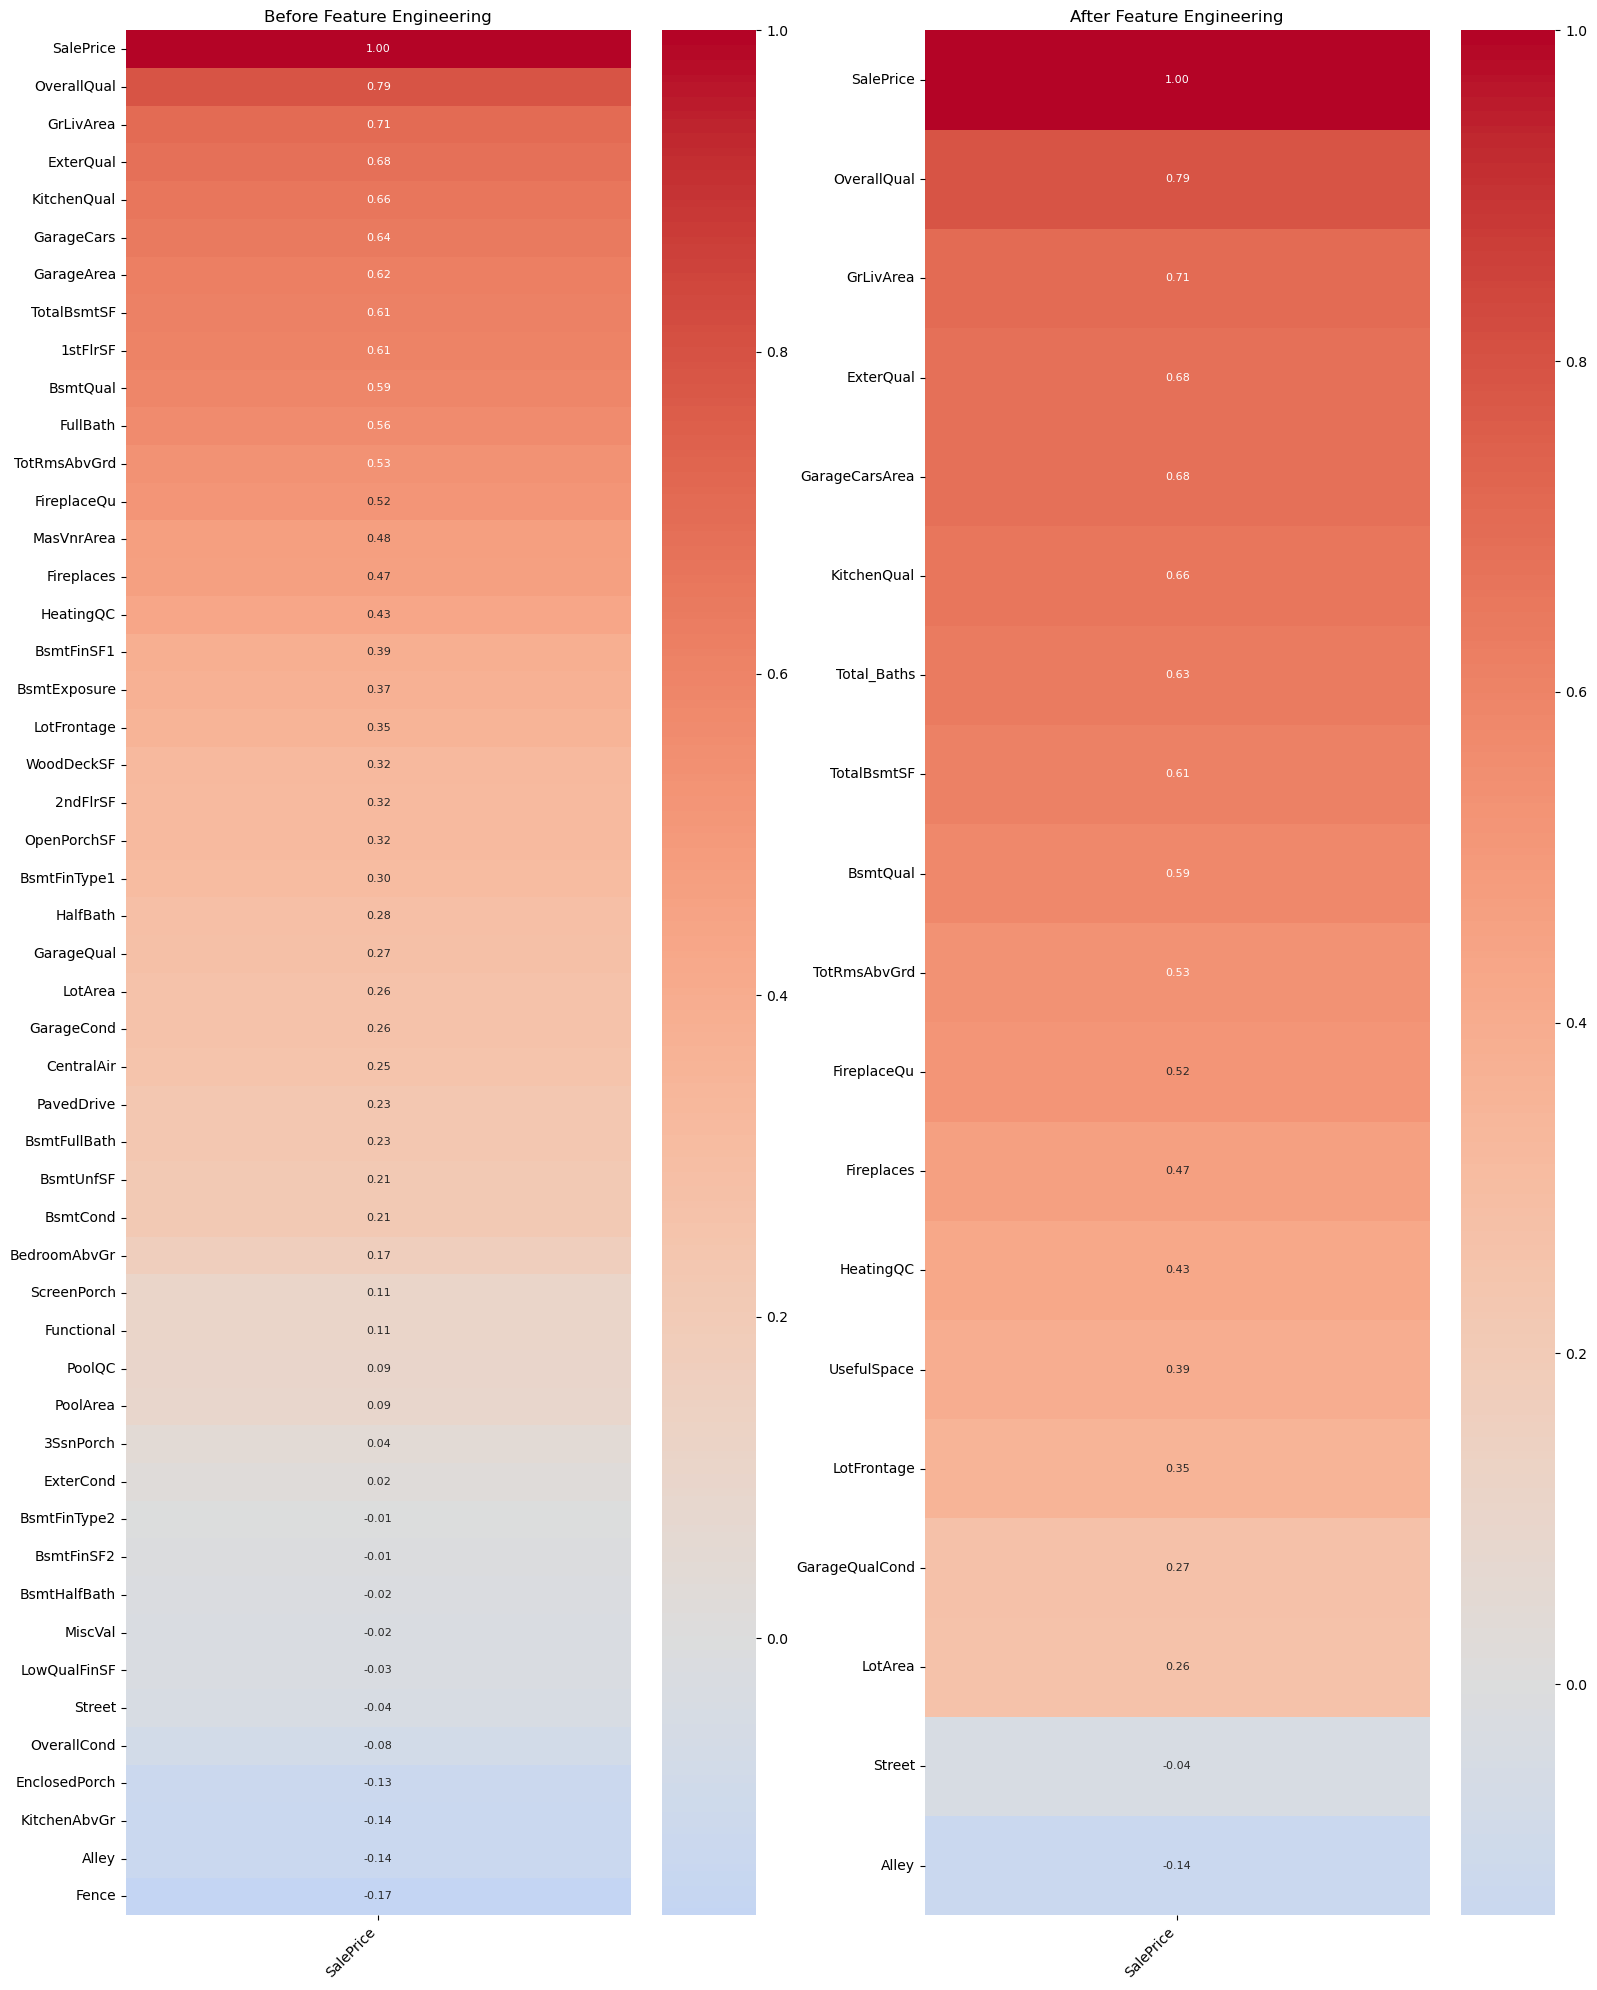

In [7]:
# --- 1. Correlaciones iniciales ---
corr_matrix = df_train[num_feats_prev].corr()
corr_with_saleprice = corr_matrix['SalePrice'].sort_values(ascending=False)

# --- 2. Correlaciones después del feature engineering ---
corr_matrix2 = df_train[final_num].corr()
corr_with_saleprice2 = corr_matrix2['SalePrice'].sort_values(ascending=False)

# --- 3. Plot: comparativa lado a lado ---
num_features = max(len(corr_with_saleprice), len(corr_with_saleprice2)); fig_height = max(6, num_features * 0.4); plt.figure(figsize=(16, fig_height))
plt.subplot(1, 2, 1); sns.heatmap(corr_with_saleprice.to_frame(), annot=True, cmap='coolwarm', center=0, fmt=".2f", annot_kws={"size": 8})
plt.title('Before Feature Engineering', fontsize=12); plt.yticks(rotation=0); plt.xticks(rotation=45, ha='right')
plt.subplot(1, 2, 2); sns.heatmap(corr_with_saleprice2.to_frame(), annot=True, cmap='coolwarm', center=0, fmt=".2f", annot_kws={"size": 8})
plt.title('After Feature Engineering', fontsize=12); plt.yticks(rotation=0);
plt.xticks(rotation=45, ha='right'); plt.tight_layout(rect=[0, 0, 1, 1]); plt.show()

### 5. Outliers and Skewness correction

#### 5. 1. Capping outliers in numeric features

In [8]:
# EVALUATE THIS CELL ONLY ONCE
def apply_iqr_capping(df_train, columns, fold=1.5):
    for col in [c for c in columns if c != 'SalePrice']:
        # Calculation of Q1, Q3 and IQR only to df_train)
        Q1 = df_train[col].quantile(0.25)
        Q3 = df_train[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Threshold definition
        lower_limit = Q1 - fold * IQR
        upper_limit = Q3 + fold * IQR
        
        # Capping application to df_train
        df_train[col] = np.where(df_train[col] > upper_limit, upper_limit, df_train[col])
        df_train[col] = np.where(df_train[col] < lower_limit, lower_limit, df_train[col])

        # Capping en test con los mismos límites
        df_test[col] = np.where(df_test[col] > upper_limit, upper_limit, df_test[col])
        df_test[col] = np.where(df_test[col] < lower_limit, lower_limit, df_test[col])
        
    print(f"Capping (1.5 * IQR) applied to {len(columns)} numerical variables in TRAIN and TEST.")
    return df_train

# Function application
df_train_final = apply_iqr_capping(df_train_final, df_train_final_num.columns)
print('Beware of data compression for repeated cell runs without restoring the original data.')

Capping (1.5 * IQR) applied to 19 numerical variables in TRAIN.
Beware of data compression for repeated cell runs without restoring the original data.


#### 5. 2. Automatic skew correction for features using the 0.75 skewness threshold

In [9]:
# Skewness calculation for all numerical columns
skewness = df_train_final[[col for col in df_train_final_num.columns if col != 'SalePrice']].apply(lambda x: skew(x.dropna()))
skewed_cols = skewness[abs(skewness) > 0.75].index 

# Application of log1p function
for col in skewed_cols:
    df_train_final[col] = np.log1p(df_train_final[col])
    if col in df_test.columns:
        df_test_final[col] = np.log1p(df_test_final[col])
print(list(skewed_cols))

['ExterQual', 'UsefulSpace']


### 6. Missing data removal, One-Hot-Encoding, removal of zero-variance features, Standardization and MICE Application

#### 6. 1. Preliminary summary

In [10]:
# Missing values counting
nan_count = df_train_final.isnull().sum()
    
# Percentage calculation
nan_percentage = 100 * nan_count / len(df_train_final)

# Crear un a tabla con count y percentage
nan_table = pd.DataFrame({'Valores Faltantes': nan_count, 'Porcentaje Faltante': nan_percentage})
nan_table = nan_table[nan_table['Valores Faltantes'] != 0].sort_values('Porcentaje Faltante', ascending=False).round(1)
display(nan_table)

,Valores Faltantes,Porcentaje Faltante
MiscFeature,1406,96.3
MasVnrType,872,59.7
LotFrontage,259,17.7
GarageType,81,5.5
GarageYrBlt,81,5.5
GarageFinish,81,5.5
MasVnrArea,8,0.5
Electrical,1,0.1


#### 6. 2. Removal of features with over 15% missing values

In [11]:
nan_percentage_train = 100 * df_train_final.isnull().sum() / len(df_train_final)

# List of columns with over 15% missing values
UMBRAL = 15.0 
columnas_a_eliminar = nan_percentage_train[nan_percentage_train > UMBRAL].index.tolist()

# Dropping columns in df_train
df_train_final = df_train_final.drop(columns=columnas_a_eliminar)

# Eliminar las columnas correspondientes de df_test
# 'errors="ignore"' because SalePrice does not appear in df_test
df_test_final = df_test_final.drop(columns=columnas_a_eliminar, errors='ignore')

#### 6. 3. One-Hot-Encoding (OHE)

In [12]:
# Select target variable (y_train), features for training (X_train), and create a copy of the test set (X_test)
y_train = df_train_final['SalePrice']
X_train = df_train_final.drop('SalePrice', axis=1)
X_test = df_test_final.copy() 

# Concatenation to assure OHE has the same columns 
df_combined = pd.concat([X_train, X_test], ignore_index=True)

# OHE application
df_combined_encoded = pd.get_dummies(df_combined, dtype=int)

# Separation
X_train_encoded = df_combined_encoded.iloc[:len(X_train)]
X_test_encoded = df_combined_encoded.iloc[len(X_train):]

print('Shape of df_train_final:', df_train_final.shape)
print('Shape of X_train:', X_train.shape)
print('Shape of X_train_encoded:', X_train_encoded.shape, end='\n\n')
print('Shape of df_train_final:', df_test_final.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of X_test_encoded:', X_test_encoded.shape)

Shape of df_train_final: (1460, 55)
Shape of X_train: (1460, 54)
Shape of X_train_encoded: (1460, 222)

Shape of df_train_final: (1459, 54)
Shape of X_test: (1459, 54)
Shape of X_test_encoded: (1459, 222)


#### 6. 4. Removal of zero-variance features

In [13]:
# Identification of features with standard deviation equal to zero
cols_to_drop = [col for col in X_train_encoded.columns if X_train_encoded[col].std() == 0]

# Features
if cols_to_drop:
    print("Variables eliminadas por tener Varianza Cero (Std = 0):")
    print(cols_to_drop)
else:
    print("No se eliminó ninguna variable por tener Varianza Cero.")

# Removal of features
X_train_encoded.drop(columns=cols_to_drop, inplace=True)
X_test_encoded.drop(columns=cols_to_drop, inplace=True)

X_train_encoded = X_train_encoded.astype(float)
X_test_encoded = X_test_encoded.astype(float)

Variables eliminadas por tener Varianza Cero (Std = 0):
['Street', 'Alley', 'MSSubClass_150']


#### 6. 6. Standardization

In [14]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded) 
X_test_scaled = scaler.transform(X_test_encoded)      

# Conversion to DataFrame 
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)

test_ID = df_test.Id

# Eliminar la columna 'Id' de X_train_imputed y X_test_imputed
X_train_scaled.drop(columns=['Id'], inplace=True, errors='ignore')
X_test_scaled.drop(columns=['Id'], inplace=True, errors='ignore')

#### 6. 7. MICE Application and drop `Id`

In [15]:
mice_imputer = IterativeImputer(
    max_iter=10, 
    random_state=42, 
    estimator=RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42), # Use of RF to also capturing non-linears
    verbose=2 
)

# Fit and impute using ONLY the training set
X_train_imputed_scaled = mice_imputer.fit_transform(X_train_scaled)
X_train_imputed = pd.DataFrame(X_train_imputed_scaled, columns=X_train_scaled.columns)
X_train_imputed['SalePrice'] = y_train.values # Reintegrar SalePrice

# Impute the TEST set using the fitted model
X_test_imputed_scaled = mice_imputer.transform(X_test_scaled)
X_test_imputed = pd.DataFrame(X_test_imputed_scaled, columns=X_test_scaled.columns)

[IterativeImputer] Completing matrix with shape (1460, 218)
[IterativeImputer] Ending imputation round 1/10, elapsed time 18.72
[IterativeImputer] Change: 2.1967292892216626, scaled tolerance: 0.03819685850956858 
[IterativeImputer] Ending imputation round 2/10, elapsed time 37.79
[IterativeImputer] Change: 0.10165529896347886, scaled tolerance: 0.03819685850956858 
[IterativeImputer] Ending imputation round 3/10, elapsed time 54.89
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03819685850956858 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1459, 218)
[IterativeImputer] Ending imputation round 1/3, elapsed time 0.01
[IterativeImputer] Ending imputation round 2/3, elapsed time 0.02
[IterativeImputer] Ending imputation round 3/3, elapsed time 0.04


#### 6. 8. Verify that there are no more `Nan` values

In [16]:
# Missing values counting
nan_count = X_train_imputed.isnull().sum()
    
# Percentage calculation
nan_percentage = 100 * nan_count / len(X_train_imputed)

# Crear un a tabla con count y percentage
nan_table = pd.DataFrame({'Valores Faltantes': nan_count, 'Porcentaje Faltante': nan_percentage})
nan_table = nan_table[nan_table['Valores Faltantes'] != 0].sort_values('Porcentaje Faltante', ascending=False).round(1)
display(nan_table)

,Valores Faltantes,Porcentaje Faltante


### 7. Exploration of `SalePrice` distribution

- Check `df[val].describe()` for bad values.
- Histogram of the variable

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


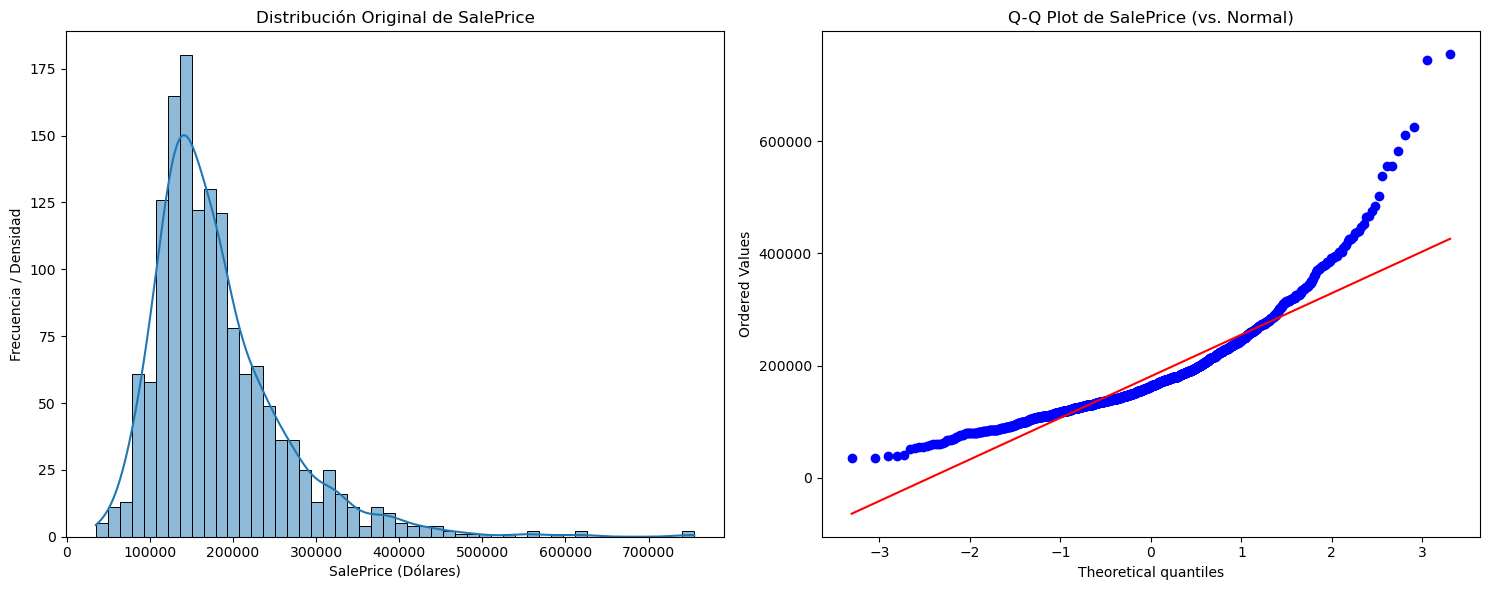

Skewness: 1.882876
Kurtosis: 6.536282


In [17]:
# Variable .describe()
print(y_train.describe())

plt.figure(figsize=(15, 6))
# --- Subplot 1: Histogram and Density Curve (KDE) ---
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, bins=50)
plt.title('Distribución Original de SalePrice')
plt.xlabel('SalePrice (Dólares)')
plt.ylabel('Frecuencia / Densidad')

# --- Subplot 2: Q-Q Plot (Quantile-Quantile Plot) ---
# Compares the distribution of SalePrice with a theoretical normal distribution
plt.subplot(1, 2, 2)
probplot(y_train, dist="norm", plot=plt)
plt.title('Q-Q Plot de SalePrice (vs. Normal)')
plt.tight_layout()
plt.show()

# Skewness and Kurtosis
print("Skewness: %f" % y_train.skew())
print("Kurtosis: %f" % y_train.kurt())

#### 7. 1. Log Transform

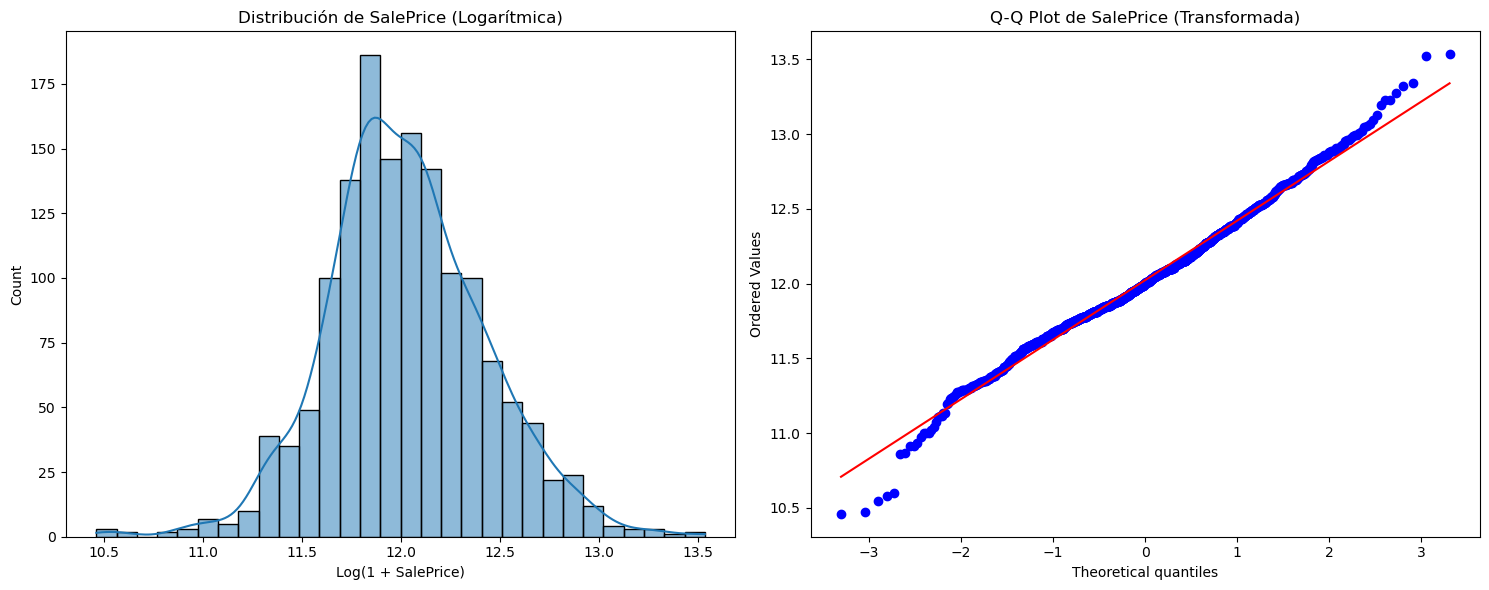

Skewness: 0.121347
Kurtosis: 0.809519


In [18]:
# Transformation applciation
y_train = np.log1p(y_train)

# Visualization
plt.figure(figsize=(15, 6))

# Histogram of transformed SalePrice
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, bins=30)
plt.title('Distribución de SalePrice (Logarítmica)')
plt.xlabel('Log(1 + SalePrice)')

# Q-Q Plot of transformed SalePrice
plt.subplot(1, 2, 2)
probplot(y_train, dist="norm", plot=plt)
plt.title('Q-Q Plot de SalePrice (Transformada)')

plt.tight_layout()
plt.show()

# Skewness and Kurtosis
print("Skewness: %f" % y_train.skew())
print("Kurtosis: %f" % y_train.kurt())

### 8. Model Fitting

In [19]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

#### 8. 1. Data Preparation

In [20]:
X = X_train_imputed.drop(columns=['SalePrice']).copy()
y = y_train.copy() 
X_test_final = X_test_imputed.copy()
print("Shapes:", X.shape, y.shape, X_test_final.shape)

Shapes: (1460, 218) (1460,) (1459, 218)


#### 8. 2. RMSE CV function

In [21]:
def cv_rmse(model, X, y, folds=4, random_state=42):
    kf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    # Negative MSE scoring for cross_val_score compatibility
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf, n_jobs=-1)
    rmses = np.sqrt(-scores)
    return rmses.mean(), rmses.std()

#### 8. 3. Baseline: XGBoost with default parameters

In [22]:
xgb_baseline = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='auto',
    n_jobs=-1,
    verbosity=0
)

t0 = time.time()
mean_rmse_xgb, std_rmse_xgb = cv_rmse(xgb_baseline, X, y, folds=4)
t1 = time.time()
print(f"[XGB baseline] RMSE log-scale: {mean_rmse_xgb:.5f} ± {std_rmse_xgb:.5f}  (t={t1-t0:.1f}s)")

[XGB baseline] RMSE log-scale: 0.13195 ± 0.00649  (t=4.5s)


#### 8. 4. Baseline: ElasticNet (regularized)

In [23]:
# Elastic Net Regression
elastic = ElasticNet(random_state=42, max_iter=5000)

t0 = time.time()
mean_rmse_enet, std_rmse_enet = cv_rmse(elastic, X, y, folds=4)
t1 = time.time()
print(f"[ElasticNet baseline] RMSE log-scale: {mean_rmse_enet:.5f} ± {std_rmse_enet:.5f}  (t={t1-t0:.1f}s)")

[ElasticNet baseline] RMSE log-scale: 0.39957 ± 0.01761  (t=1.8s)


#### 8. 5. Hyperparameter search (RandomizedSearch) for XGBoost

In [24]:
xgb_param_dist = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.5, 1, 2, 5]
}

rs_xgb = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=xgb_param_dist,
    n_iter=25,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=4, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

t0 = time.time()
rs_xgb.fit(X, y)
t1 = time.time()
print(f"Best score (neg MSE): {rs_xgb.best_score_:.5f}")
print("Best params XGB:", rs_xgb.best_params_)
best_xgb = rs_xgb.best_estimator_

# Final CV evaluation of best estimator (4 folds)
mean_rmse_xgb_tuned, std_rmse_xgb_tuned = cv_rmse(best_xgb, X, y, folds=4)
print(f"[XGB tuned] RMSE log-scale: {mean_rmse_xgb_tuned:.5f} ± {std_rmse_xgb_tuned:.5f}")

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best score (neg MSE): -0.01713
Best params XGB: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
[XGB tuned] RMSE log-scale: 0.13073 ± 0.00640


#### 8. 6. Hyperparameter search for ElasticNet

In [25]:
enet_cv = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .9], 
                       alphas=np.logspace(-4, 0, 30),
                       cv=5, n_jobs=-1, random_state=42, max_iter=5000)
enet_cv.fit(X, y)
print("ElasticNetCV: mejor alpha:", enet_cv.alpha_, " mejor l1_ratio:", enet_cv.l1_ratio_)

# CV score with best hyperparameters
enet_best = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_, max_iter=5000, random_state=42)
mean_rmse_enet_tuned, std_rmse_enet_tuned = cv_rmse(enet_best, X, y, folds=4)
print(f"[ElasticNet tuned] RMSE log-scale: {mean_rmse_enet_tuned:.5f} ± {std_rmse_enet_tuned:.5f}")

ElasticNetCV: mejor alpha: 0.011721022975334805  mejor l1_ratio: 0.3
[ElasticNet tuned] RMSE log-scale: 0.13035 ± 0.01174


### 9. Learning Curve (XGB) - overfitting inspection

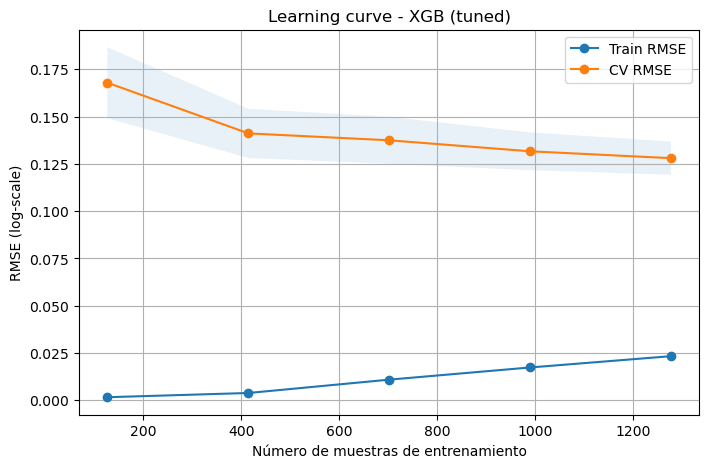

In [26]:
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, scoring='neg_mean_squared_error'):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                            scoring=scoring, n_jobs=-1,
                                                            train_sizes=np.linspace(0.1, 1.0, 5), random_state=42)
    train_rmse = np.sqrt(-train_scores)
    test_rmse = np.sqrt(-test_scores)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_rmse.mean(axis=1), 'o-', label="Train RMSE")
    plt.plot(train_sizes, test_rmse.mean(axis=1), 'o-', label="CV RMSE")
    plt.fill_between(train_sizes, test_rmse.mean(axis=1)-test_rmse.std(axis=1),
                     test_rmse.mean(axis=1)+test_rmse.std(axis=1), alpha=0.1)
    plt.xlabel("Número de muestras de entrenamiento")
    plt.ylabel("RMSE (log-scale)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curve(best_xgb, X, y, title="Learning curve - XGB (tuned)", cv=KFold(n_splits=8, shuffle=True, random_state=42))


Top 30 Important features (XGB):
OverallQual              0.165836
ExterQual                0.090007
CentralAir               0.064850
KitchenQual              0.049011
MSZoning_RM              0.032109
Total_Baths              0.030111
GrLivArea                0.022422
LandContour_Bnk          0.017270
FireplaceQu              0.016161
MSZoning_C (all)         0.015499
GarageType_Attchd        0.015018
GarageCarsArea           0.014187
MSZoning_RL              0.013556
Neighborhood_Crawfor     0.013300
TotalBsmtSF              0.011306
GarageType_Detchd        0.011078
Functional               0.010717
Fireplaces               0.010585
BsmtQual                 0.010046
BldgType_1Fam            0.009630
LotShape_IR3             0.008814
PavedDrive               0.008471
Exterior1st_BrkFace      0.008363
Neighborhood_Edwards     0.007989
PoolQC                   0.007681
SaleCondition_Abnorml    0.007468
MSSubClass_70            0.006578
YearRemodAdd             0.006528
HouseStyle_SLv

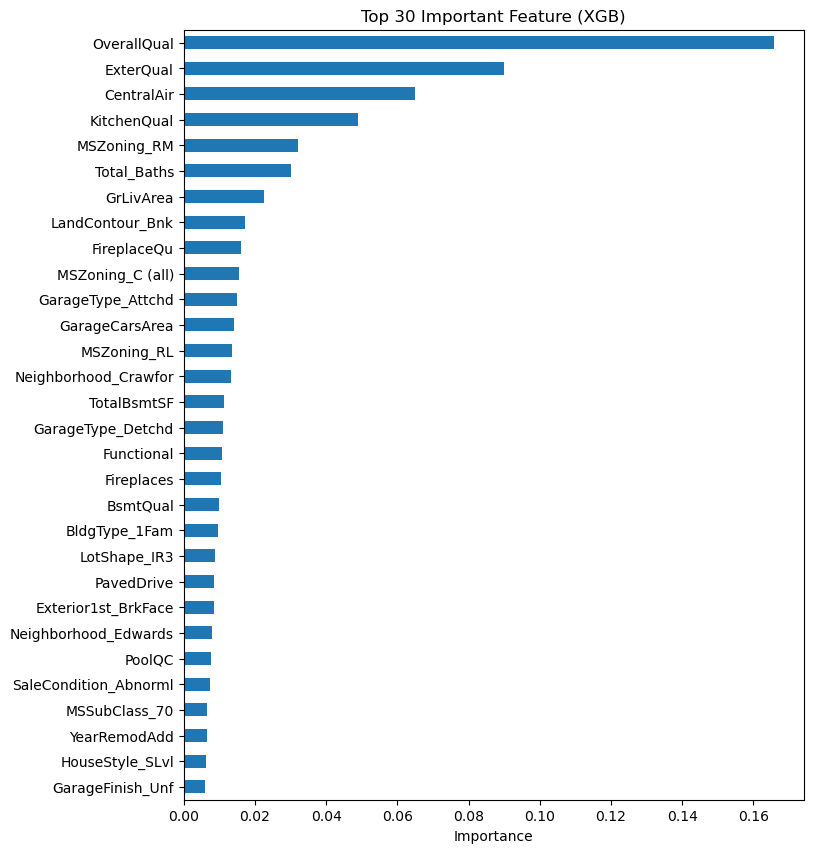

In [27]:
fi = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 30 Important features (XGB):")
print(fi.head(30))

plt.figure(figsize=(8,10))
fi.head(30).sort_values().plot(kind='barh')
plt.title("Top 30 Important Feature (XGB)")
plt.xlabel("Importance")
plt.show()

In [28]:
sfm = SelectFromModel(best_xgb, threshold="median", prefit=True) 
X_reduced = sfm.transform(X)
X_test_reduced = sfm.transform(X_test_final)

print("Original Shape X:", X.shape)
print("Reduced Shape X :", X_reduced.shape)

# Re-evaluation of XGB over reduced set
mean_rmse_xgb_reduced, std_rmse_xgb_reduced = cv_rmse(best_xgb, X_reduced, y, folds=8)
print(f"[XGB reduced] RMSE log-scale: {mean_rmse_xgb_reduced:.5f} ± {std_rmse_xgb_reduced:.5f}")

Original Shape X: (1460, 218)
Reduced Shape X : (1460, 109)
[XGB reduced] RMSE log-scale: 0.12639 ± 0.00603


In [29]:
# Entrenamos los modelos finales sobre el conjunto de entrenamiento REDUCIDO
best_xgb.fit(X_reduced, y) 
enet_best.fit(X_reduced, y)

# Predicciones log-scale en test (usando el conjunto de prueba reducido)
pred_xgb_log = best_xgb.predict(X_test_reduced) 
pred_enet_log = enet_best.predict(X_test_reduced) 

# Combinación
pred_ensemble_log = (pred_xgb_log) * 0.67 + (pred_enet_log) * 0.33

In [30]:
pred_ensemble = np.expm1(pred_ensemble_log)
pred_xgb = np.expm1(pred_xgb_log)
pred_enet = np.expm1(pred_enet_log)

In [ ]:
submission = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': pred_ensemble
})
submission.to_csv('submission.csv', index=False)

In [32]:
submission.SalePrice

0       116645.349775
1       160357.247825
2       180996.890158
3       193492.474603
4       187343.187871
            ...      
1454     81309.292717
1455     80980.026468
1456    155211.649016
1457    116121.089193
1458    221707.116367
Name: SalePrice, Length: 1459, dtype: float64